# 802.11ad : Vehicular experiments

The fact that we could even get some 802.11ad connectivity during the vehicular experiments was surprising. 

As such, we decided to look a bit deeper.

### Questions to answer here:

* For how long does connectivity last? How good is it in terms of throughput? Is 802.11ad's throughput good enough to consider it over 802.11ac?
* Where in the map does 802.11ad connectivity work?
* During the experiments, we've noticed that there is a gap between having the vehicle within range of the AP and the establishment of 802.11ad connectivity. How long is this gap? And why is that?


## Pre-processing

### Imports and definitions

In [11]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import hashlib
import geopandas as gp
import mapping.openstreetmap as osm
import mapping.utils
import matplotlib
import matplotlib.pyplot as plt
import timeit
import shapely
import contextily as ctx
import numpy as np

warnings.filterwarnings('ignore')
base_dir = '/Volumes/data/vehicular-traces-gaia'

### Functions

In [12]:
def interpol_gps(data, subset, timedate_column = 'timestamp'):
    # FIXME : still don't know how to do this without copying, hence the variable '_data'
    to_interpol = data[[timedate_column] + subset]
    # use pandas native time-based interpolation, which requires a datetime index
    # FIXME : the type of interpolation should be defined as a parameter later on
    to_interpol['datetime'] = pd.to_datetime(to_interpol[timedate_column], unit = 's')
    to_interpol.set_index(['datetime'], inplace = True)
    to_interpol.interpolate(method = 'time', inplace = True)
    # update subset columns w/ the interpolated values
    data.update(to_interpol[subset].reset_index(drop = True))

# merge gps data with throughput for each 802.11 type (n, ac, ad)
def get_gps_thghpt(trace_nr, with_gps = True):
    
    gps_data = pd.read_csv(os.path.join(base_dir, ('m1/trace-%s/gps-log.csv' % (trace_nr))))
    gps_data['timestamp'] = gps_data['timestamp'].astype(int)
    trace_data = gps_data[['timestamp', 'speed', 'lon', 'lat']]
    
    tghpt_files = {'m1' : ['consumer.1.out', 'n'], 'w4' : ['consumer.1.out', 'ac'], 'w4/tp-03' : ['consumer.5202.1.out', 'ad']}
    for node in tghpt_files:
        filename = tghpt_files[node][0]
        cname = tghpt_files[node][1]
        
        tghpt_data = pd.read_csv(os.path.join(base_dir, ('%s/trace-%s/%s' % (node, trace_nr, filename))), names = ['timestamp', 'rcvd-pkt', 'rcvd-bytes', 'duration', cname])
        trace_data = pd.merge(tghpt_data[['timestamp', cname]], trace_data, on = ['timestamp'], how = 'left')
    
    trace_data['trace-nr'] = trace_nr
    return trace_data

#trace_nrs = ['301', '302', '303', '304', '401', '402', '403', '404', '405']
trace_nrs = ['402']
trace_data = pd.DataFrame()
for trace_nr in trace_nrs:
    trace_data = pd.concat([trace_data, get_gps_thghpt(trace_nr)])
    
# gps (lat, lon) interpolation
interpol_gps(trace_data, subset = ['lat', 'lon'])
trace_data = trace_data.dropna(subset = ['lat', 'lon']).reset_index(drop = True)
# distance & trajectories travelled in each block
# FIXME : using the haversine formula for short distances seems unreliable
trace_data['haversine-dist'] = mapping.utils.gps_to_dist(trace_data['lat'], trace_data['lon'], trace_data['lat'].shift(1), trace_data['lon'].shift(1))
# fix 'nan' speed gaps with haversine-dist / time
trace_data['time-diff'] = trace_data['timestamp'] - trace_data['timestamp'].shift(1)
trace_data.loc[trace_data['speed'].isnull(), 'speed'] = trace_data[trace_data['speed'].isnull()]['haversine-dist'] / trace_data[trace_data['speed'].isnull()]['time-diff']

### Divide the map in 5 m x 5 m cells

In [13]:
# intersection coords (espg:4326)
LAT  = 41.111937
LON = -8.631084
# N, S, W, E limits of bbox
LATN = LAT + 0.001
LATS = LAT - 0.001
LONE = LON + 0.001
LONW = LON - 0.001

# intersection coords (espg:3857)
LAT_3857 = 5028862.95
LON_3857 = -960807.88

bbox = [LONW, LATS, LONE, LATN]
cell_size = 5.0

# get 5 x 5 m geodataframe grid
grid, w, h = osm.extract_cells(bbox = bbox, tags = ['ctx'], cell_size = cell_size)
# add cell ids to trace_data
mapping.utils.add_cells(trace_data, cell_size = cell_size, bbox = [LONW, LATS, LONE, LATN])

### Divide 802.11ad throughput data into 'connectivity blocks'

A 802.11ad **connectivity block** is a series of continuous 1 second periods of time during which the 802.11ad AP sends data to the client (using the `gluten` app).

In [175]:
import mapping.utils

pd.set_option('display.float_format', '{:.10f}'.format)

ad_data = trace_data[['timestamp', 'speed', 'lon', 'lat', 'haversine-dist', 'ad', 'ac', 'trace-nr', 'cell_x', 'cell_y', 'cell_id']].reset_index(drop = True)
# mark row blocks of contiguous time
#ad_data['time-block'] = ((ad_data['timestamp'] - ad_data['timestamp'].shift(1) > 5)).astype(int).cumsum()
# mark contiguous row blocks with speed > 0 or speed = 0
ad_data['speed'] = ad_data['speed'].rolling(3, center = True, min_periods = 1).mean().astype(float)
ad_data['speed-block'] = 0
ad_data.loc[ad_data['speed'] > 0.1, 'speed-block'] = 1

# mark contiguous row blocks with similar time blocks, ad connectivity and speed profiles
ad_data['ad-on'] = 0
ad_data.loc[ad_data['ad'] > 0.0, 'ad-on'] = 1
ad_data['ad-block'] = ((ad_data['ad-on'].shift(1) != ad_data['ad-on']) | (ad_data['timestamp'] - ad_data['timestamp'].shift(1) > 5) | (ad_data['speed-block'].shift(1) != ad_data['speed-block'])).astype(int).cumsum()


In [176]:
ad_blocks = ad_data.groupby(['trace-nr', 'ad-block', 'speed-block']).agg({'timestamp' : lambda t : t.max() - t.min(), 'ad' : 'mean', 'ac' : 'mean', 'speed' : 'mean', 'haversine-dist' : 'sum', 'cell_id' : lambda x : set(x)}).reset_index(drop = False)
ad_blocks.rename(index = str, columns = {
    'timestamp' : 'duration'}, inplace = True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(ad_blocks[(ad_blocks['duration'] > 1.0) & (ad_blocks['speed'] > 1.0) & (ad_blocks['ad'] > 0.0)])

In [177]:
import seaborn as sb

def plot_cdf(ax, data, series, plot_configs):

    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    
    for s in series:

        data = data.sort_values(by = [s['var']])
        if 'counts' not in data:
            cdf = data.groupby([s['var']]).size().reset_index(name = 'counts')
        else:
            cdf = data

        cdf['counts'] = np.array(cdf['counts'].cumsum(), dtype = float)
        cdf['counts'] = cdf['counts'] / cdf['counts'].values[-1]

        ax.plot(cdf[s['var']], cdf['counts'], 
            alpha = .75,
            linewidth = 1.00, 
            color = s['color'], 
            linestyle = '-')

    ax.set_ylabel("CDF")
    ax.set_yticks(np.arange(0.0, 1.1, 0.25))
    
    ax.tick_params(axis = 'both', which = 'major')
    ax.tick_params(axis = 'both', which = 'minor')

def plot_pdf(ax, data, series, plot_configs):

    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax2 = ax.twinx()
    
    max_ax2 = 0.0
    for s in series:        
        # pdf on main axis
        sb.kdeplot(data.sort_values(by = [s['var']], ascending = True)[s['var']], ax = ax, color = s['color'], label = s['label'])
        ax.set_ylabel('pdf')

        # absolute count on secondary axis
        counts = data.groupby([s['var']]).size().reset_index(drop = False, name = 'count')
        counts = counts.sort_values(by = [s['var']])
        ax2.plot(counts[s['var']], counts['count'], color = s['color'], linewidth = 0.0, marker = '.', markersize = 10.0, alpha = .5)
        
        if counts['count'].max() > max_ax2:
            max_ax2 = counts['count'].max()
        
    ax2.set_ylabel('qty')
    ax2.set_ylim([0, max_ax2 + 1])
            
def plot_distribution(ax, data, var, plot_configs = {}):
    
    ax.set_title(plot_configs['title'])
    
    if plot_configs['plot-type'] == 'cdf':
        plot_cdf(ax, data, var, plot_configs)
    elif plot_configs['plot-type'] == 'pdf':
        plot_pdf(ax, data, var, plot_configs)

    # x-axis
    ax.set_xlabel(plot_configs['x-label'])
    ax.set_xlim(plot_configs['x-lim'])
    ax.set_xscale(plot_configs['x-type'])


## For how long does connectivity last? How good is it in terms of throughput?


### When the vehicle is moving


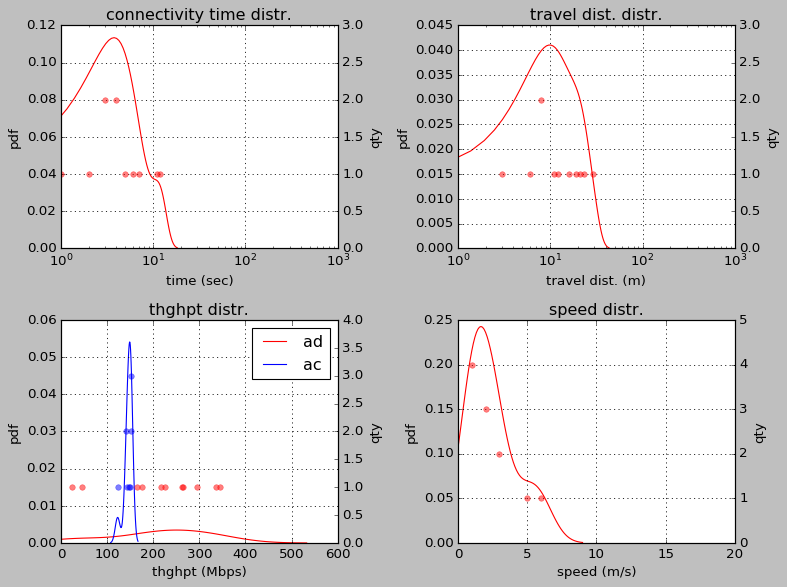

In [178]:
variables = {
    'time' : {
        'series' : [
            {'var' : 'duration',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'time (sec)',
        'x-lim' : [1.0, 1000.0],
        'x-type' : 'log',
        'plot-type' : 'pdf',
        'title' : 'connectivity time distr.',
    },
    'dist' : {
        'series' : [
            {'var' : 'haversine-dist',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'travel dist. (m)',
        'x-lim' : [1.0, 1000.0],
        'x-type' : 'log',
        'plot-type' : 'pdf',
        'title' : 'travel dist. distr.',
    },
    'throughput' : {
        'series' : [
            {'var' : 'ad',
            'color' : 'red',
            'label' : 'ad'},
            {'var' : 'ac',
            'color' : 'blue',
            'label' : 'ac'},
        ],
        'x-label' : 'thghpt (Mbps)',
        'x-lim' : [0.0, 600.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'thghpt distr.',
        'ax' : None,
    },
    'speed' : {
        'series' : [
            {'var' : 'speed',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'speed (m/s)',
        'x-lim' : [0.0, 20.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'speed distr.',
    },
}

# data to plot : car moves
to_plot = ad_blocks[(ad_blocks['duration'] > 0.0) & (ad_blocks['speed'] >= 1.0) & (ad_blocks['ad'] > 0.0)]
to_plot['haversine-dist'] = to_plot['haversine-dist'].apply(lambda x : round(x))
to_plot['speed'] = to_plot['speed'].apply(lambda x : round(x))
to_plot['ad'] = to_plot['ad'].apply(lambda x : round(x))
to_plot['ac'] = to_plot['ac'].apply(lambda x : round(x))

plt.style.use('classic')
fig = plt.figure(figsize = ((10.0), (7.5)))

plot_configs = {'x-label' : '', 'y-label' : 'pdf', 'title' : '', 'color' : 'blue'}
for i, var in enumerate(variables.keys()):
    
    plot_configs['x-label'] = variables[var]['x-label']
    plot_configs['x-lim'] = variables[var]['x-lim']
    plot_configs['x-type'] = variables[var]['x-type']
    plot_configs['plot-type'] = variables[var]['plot-type']
    plot_configs['title'] = variables[var]['title']
    
    ax = fig.add_subplot(2, 2, i + 1)
    
    plot_distribution(ax, to_plot, var = variables[var]['series'], plot_configs = plot_configs)
    
fig.tight_layout()
plt.show()

* Connectivity over short periods (1 to 10 sec), periods longer than 10 sec are likely to be due to GPS errors?
* Nevertheless, 802.11ad's mean throughput is higher than 802.11ac's during the same period, though with high variance
* However, in the periods in which 802.11ad is advantageous, speeds are very low (< 3 m/s)
* **There are only 10 examples of periods in which we had 802.11ad connectivity while moving**

In [179]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ad_blocks[(ad_blocks['duration'] > 1.0) & (ad_blocks['speed'] >= 1.0) & (ad_blocks['ad'] > 0.0)][['ad-block', 'duration', 'ad', 'ac', 'speed']])

     ad-block  duration             ad             ac        speed
1           2        11 263.3045833333 141.6309166667 2.2835555556
9          10         4 263.5352000000 150.6222000000 1.1317333333
26         27         3 175.1830000000 150.9975000000 1.8304166667
66         67         3 215.7512500000 152.3785000000 1.1746666667
68         69         2  44.6980000000 122.7530000000 5.3902222222
80         81         6 225.8957142857 144.1315714286 3.1553809524
86         87         5 345.3646666667 150.8918333333 2.4777777778
94         95         4 164.5932000000 152.4898000000 1.3272000000
102       103        12 295.0974615385 149.8287692308 1.4890769231
107       108         7 335.6778750000 146.6463750000 2.9258750000


### When the vehicle is stopped

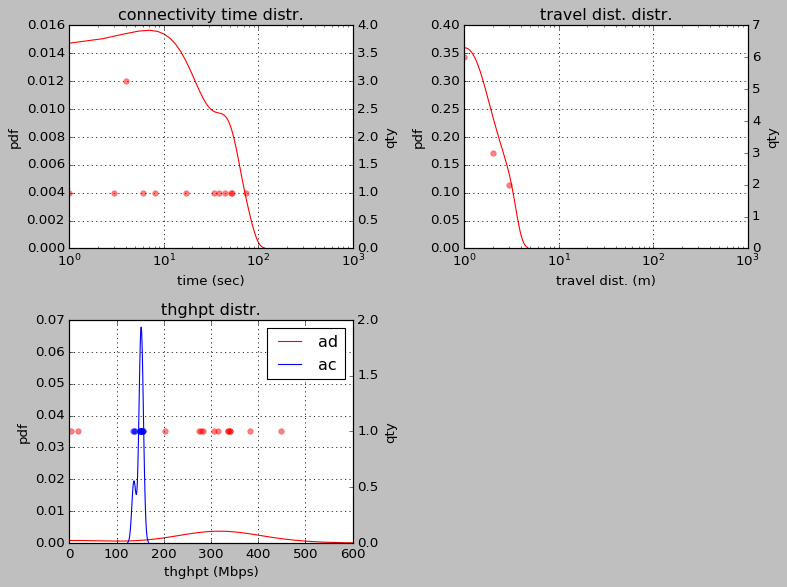

In [180]:
variables = {
    'time' : {
        'series' : [
            {'var' : 'duration',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'time (sec)',
        'x-lim' : [1.0, 1000.0],
        'x-type' : 'log',
        'plot-type' : 'pdf',
        'title' : 'connectivity time distr.'
    },
    'dist' : {
        'series' : [
            {'var' : 'haversine-dist',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'travel dist. (m)',
        'x-lim' : [1.0, 1000.0],
        'x-type' : 'log',
        'plot-type' : 'pdf',
        'title' : 'travel dist. distr.'
    },
    'throughput' : {
        'series' : [
            {'var' : 'ad',
            'color' : 'red',
            'label' : 'ad'},
            {'var' : 'ac',
            'color' : 'blue',
            'label' : 'ac'},
        ],
        'x-label' : 'thghpt (Mbps)',
        'x-lim' : [0.0, 600.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'thghpt distr.'
    }
}

# data to plot : car's not moving
wait_blocks = ad_blocks[(ad_blocks['duration'] > 0.0) & (ad_blocks['speed'] < 0.1) & (ad_blocks['ad'] > 0.0)]
wait_blocks['haversine-dist'] = wait_blocks['haversine-dist'].apply(lambda x : round(x))
wait_blocks['speed'] = wait_blocks['speed'].apply(lambda x : round(x))
wait_blocks['ad'] = wait_blocks['ad'].apply(lambda x : round(x))

plt.style.use('classic')
fig = plt.figure(figsize = ((10.0), (7.5)))

plot_configs = {'x-label' : '', 'y-label' : 'pdf', 'title' : '', 'color' : 'blue'}
for i, var in enumerate(variables.keys()):
    plot_configs['x-label'] = variables[var]['x-label']
    plot_configs['x-lim'] = variables[var]['x-lim']
    plot_configs['x-type'] = variables[var]['x-type']
    plot_configs['plot-type'] = variables[var]['plot-type']
    plot_configs['title'] = variables[var]['title']

    ax = fig.add_subplot(2, 2, i + 1)
    plot_distribution(ax, wait_blocks, var = variables[var]['series'], plot_configs = plot_configs)

fig.tight_layout()
plt.show()

* 802.11ad throughput is higher than moving case
* 802.11ad's mean is higher than 802.11ac, again with larger variance
* Travelled distance values due to GPS errors
* **There are only 13 examples of 802.11ad connectivity periods while the vehicle was stopped**

In [182]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ad_blocks[(ad_blocks['duration'] > 1.0) & (ad_blocks['speed'] < 0.1) & (ad_blocks['ad'] > 0.0)][['ad-block', 'duration', 'ad', 'ac', 'speed']])

     ad-block  duration             ad             ac        speed
0           1        53 340.7490185185 135.4062777778 0.0012716049
4           5        38 306.0683076923 150.6640000000 0.0000000000
6           7        17 281.9639444444 149.8143333333 0.0000000000
8           9        45 339.6544130435 149.2868913043 0.0000000000
27         28        52 336.3956226415 151.0212075472 0.0009685535
45         46         4   4.2324000000 135.8290000000 0.0000000000
49         50        34 383.4999142857 152.5930571429 0.0000000000
59         60        75 337.3867368421 153.0297105263 0.0000000000
65         66         6 314.8834285714 149.9892857143 0.0000000000
75         76         8  17.9047777778 156.2453333333 0.0095185185
79         80         3 279.0057500000 153.9417500000 0.0000000000
85         86         4 203.2304000000 139.2016000000 0.0000000000
106       107         4 274.9060000000 154.9488000000 0.0000000000


## Trajectories

### Code

In [183]:
graphs_dir = '/Volumes/data/vehicular-traces-gaia/graphs/movement-ad'

def add_basemap(ax, zoom, url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):

    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom = zoom, url = url)
    ax.imshow(basemap, extent = extent, interpolation = 'bilinear', alpha = 1.0)
    
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

to_plot = to_plot.reset_index(drop = True)
cells_to_display = []
for i, row in to_plot.iterrows():
    cells_to_display += list(row['cell_id'])
    
full_grid = ad_data[ad_data['cell_id'].isin(cells_to_display)].groupby(['cell_id'])['ad'].mean().reset_index(drop = False, name = 'value')
full_grid = pd.merge(grid, full_grid, on = ['cell_id'], how = 'inner')
full_grid = full_grid.to_crs(epsg = 3857)

def plot_map(ax, data, 
         params = {
            'name' : 'sample-map',
            'title' : '# of data samples per 5x5 m cell' 
        }):
    
    # FIXME : use 'transparent' grid to make sure the whole picture shows up
    full_grid.plot(ax = ax, zorder = 5, column = 'value', cmap = 'YlOrRd', legend = False, alpha = 0.0)
    add_basemap(ax, zoom = 17)
    
    # map tiles are typically provided in Web Mercator (EPSG 3857), so we need to make sure to convert our data first to the same CRS to combine our polygons and background tiles in the same map

    to_show = data.groupby(['cell_id'])['ad'].mean().reset_index(drop = False, name = 'value')
    to_show = pd.merge(grid, to_show, on = ['cell_id'], how = 'inner')
    to_show = to_show.to_crs(epsg = 3857)
    to_show.plot(ax = ax, zorder = 5, column = 'value', cmap = 'YlOrRd', legend = True, alpha = .75)
    
    data = data.sort_values(by = ['timestamp'])
    data = pd.merge(grid, data, on = ['cell_id'], how = 'inner')
    start_pos = gp.GeoDataFrame({'geometry' : [shapely.geometry.Point(data.iloc[0]['cell_lon'], data.iloc[0]['cell_lat'])]})
    start_pos.crs = {'init' : 'epsg:4326'}
    start_pos = start_pos.to_crs(epsg = 3857)
    start_pos.plot(ax = ax, zorder = 10, color = 'green')
    
    end_pos = gp.GeoDataFrame({'geometry' : [shapely.geometry.Point(data.iloc[-1]['cell_lon'], data.iloc[-1]['cell_lat'])]})
    end_pos.crs = {'init' : 'epsg:4326'}
    end_pos = end_pos.to_crs(epsg = 3857)
    end_pos.plot(ax = ax, zorder = 10, color = 'red')

    xlim = ax.get_xlim()
    dx = (65.5 / 2.5)
    a = np.arange(LON_3857 - (dx * 10), LON_3857, dx)
    b = np.arange(LON_3857, LON_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_xticks(a.tolist() + b.tolist())
    ax.set_xticklabels(c.tolist() + d.tolist())
    ax.set_xlim(xlim)
    
    ylim = ax.get_ylim()
    a = np.arange(LAT_3857 - (dx * 10), LAT_3857, dx)
    b = np.arange(LAT_3857, LAT_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_yticks(a.tolist() + b.tolist())
    ax.set_yticklabels(c.tolist() + d.tolist())
    ax.set_ylim(ylim)
    
    ax.set_title(params['title'])
    ax.set_xlabel('xx dist (m)')
    ax.set_ylabel('yy dist (m)')
    
    fig.tight_layout()
#     plt.savefig(os.path.join(graphs_dir, ("%s.png" % (params['name']))), bbox_inches = 'tight', format = 'png')

### Trajectory plots

While the vehicle is moving, 802.11ad connectivity is achieved when the vehicle approaches the AP from the 'right' of the map (trajectories 89 and 95 seem to be exceptions or errors).

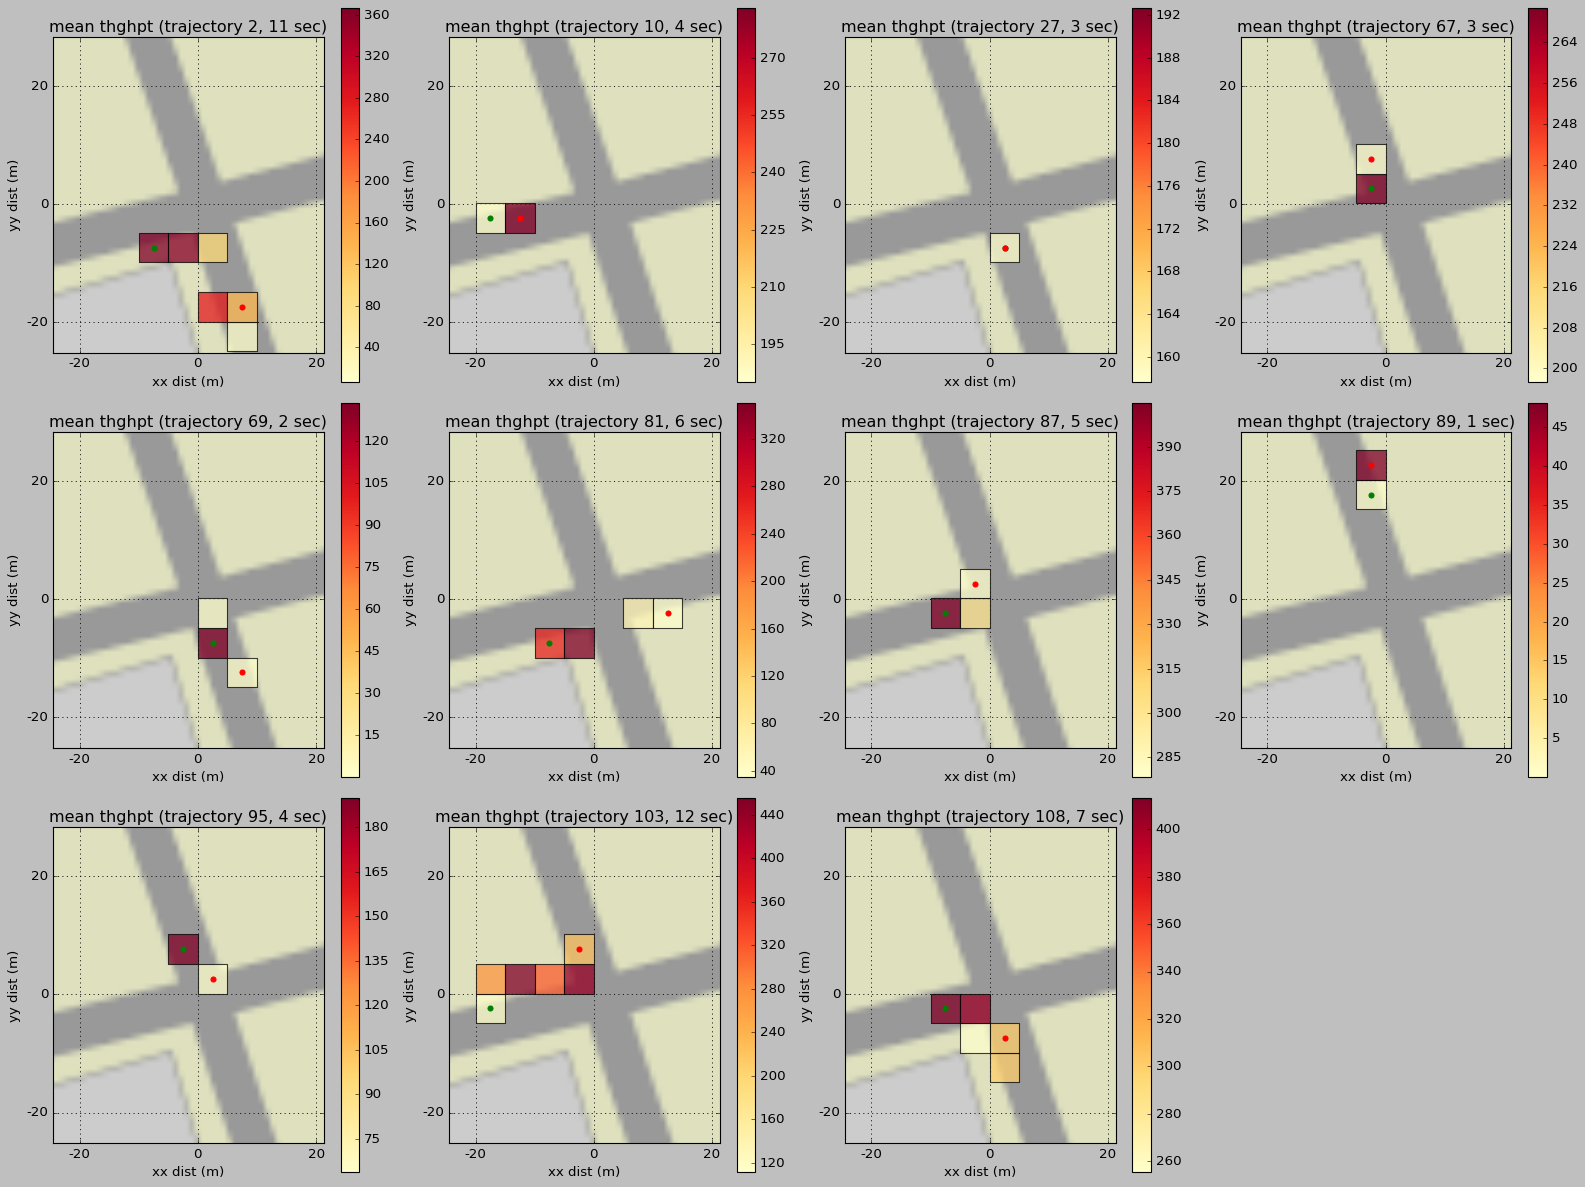

In [184]:
n_rows = np.ceil(float(len(to_plot)) / 4.0)
fig = plt.figure(figsize = (5.0 * 4.0, 5.0 * n_rows))

for i, row in to_plot.iterrows():
    
    ax = fig.add_subplot(n_rows, 4, int(i) + 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    
    ad_block = row['ad-block']
    duration = row['duration']
    plot_map(ax, ad_data[ad_data['ad-block'] == ad_block], params = {'name' : ('ad-block-%s' % (ad_block)), 'title' : ('mean thghpt (trajectory %s, %s sec)' % (ad_block, duration))})
    

## Analysis of 802.11ad connectivity time gap

In [193]:
# ad connectivity blocks (FIXME : repeated from above? why?)
conn_blocks = ad_data.groupby(['trace-nr', 'ad-block', 'speed-block']).agg({'timestamp' : [lambda t : t.max() - t.min(), 'size', 'min'], 'ad' : 'mean', 'speed' : 'mean', 'haversine-dist' : 'sum', 'cell_id' : lambda x : set(x)})
conn_blocks.columns = conn_blocks.columns.map('.'.join)
conn_blocks = conn_blocks.reset_index(drop = False)
conn_blocks.rename(index = str, columns = {
    'timestamp.<lambda_0>' : 'duration', 
    'timestamp.size' : 'samples', 
    'timestamp.min' : 'start', 
    'cell_id.<lambda>' : 'cell_id'}, inplace = True)

conn_blocks['duration.prev'] = conn_blocks['duration'].shift(1)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(conn_blocks[(conn_blocks['ad.mean'] > 0.0)][['ad-block', 'speed-block', 'start', 'duration', 'ad.mean', 'duration.prev']])

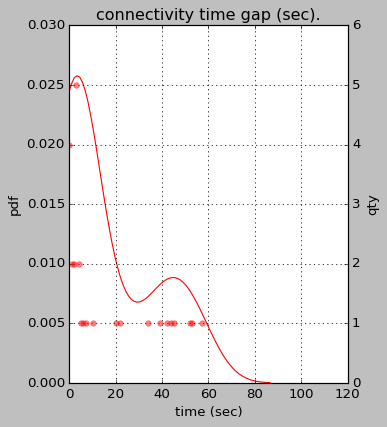

In [199]:
# plot duration of all 'stopped' blocks which immediately precede blocks w/ 802.11ad connectivity
variables = {
    'gap' : {
        'series' : [
            {'var' : 'duration.prev',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'time (sec)',
        'x-lim' : [0.0, 120.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'connectivity time gap (sec).'
    },
}

gap_blocks = conn_blocks[(conn_blocks['ad.mean'] > 0.0)].dropna()

plt.style.use('classic')
fig = plt.figure(figsize = ((5.0), (5.5)))

plot_configs = {'x-label' : '', 'y-label' : 'pdf', 'title' : '', 'color' : 'blue'}
for i, var in enumerate(variables.keys()):
    plot_configs['x-label'] = variables[var]['x-label']
    plot_configs['x-lim'] = variables[var]['x-lim']
    plot_configs['x-type'] = variables[var]['x-type']
    plot_configs['plot-type'] = variables[var]['plot-type']
    plot_configs['title'] = variables[var]['title']

    ax = fig.add_subplot(1, 1, i + 1)
    plot_distribution(ax, gap_blocks, var = variables[var]['series'], plot_configs = plot_configs)

fig.tight_layout()
plt.show()

* The connectivity gap time varies between ~1 sec and up to 60 seconds.
* Since we did not mark specific timestamps for when the car stopped and 802.11ad connectivity resumes, these time gaps are inferred and thus prone to errors.
* We've conducted more conclusive experiments in the lab.

## Sector sweep analysis

This sounds a bit off-topic, but here goes an analysis of sector sweeps:
* How long do they take and how often?
* What sectors were picked by AP and client?

In [102]:
sweep_frame_types = {360 : 'ssw', 361 : 'ssw-feedback', 362 : 'ssw-feedback-ack'}
trace_nr = '402'
sweep_data = pd.read_csv(os.path.join(base_dir, ('w4/tp-02/trace-%s/monitor.ad.sweep.csv' % (trace_nr))))

In [103]:
def convert_snr(data):
    # wlan.sswf.snr_report : encoded as 8-bit twos complement value of 4×(SNR-19), where SNR is measured in dB    
    msbs = ((data[data['wlan.fc.type_subtype'] > 360]['wlan.sswf.snr_report'].astype(int) & 0x0080)).values
    msbs = np.array([ float((int(msb) >> 7) * -128.0) for msb in msbs ])
    lsbs = data[data['wlan.fc.type_subtype'] > 360]['wlan.sswf.snr_report'] + msbs
        
    data['wlan.sswf.snr_report.converted'] = 0.0
    data.loc[data['wlan.fc.type_subtype'] > 360, 'wlan.sswf.snr_report.converted'] = ((lsbs + msbs) / 4.0) + 19.0

def chosen_sectors(data, mac_addrs = {'50:c7:bf:97:8a:a6' : 'ap', '50:c7:bf:3c:53:1c' : 'client_1', '70:4f:57:72:b2:58' : 'client_2'}):
    
    for addr in mac_addrs:
        
        if addr not in list(sweep_data['wlan.ta'].unique()):
            continue
        
        col_name = ('wlan.sswf.sector_select.%s' % (mac_addrs[addr]))
        sweep_data[col_name] = -1
        sweep_data.loc[(sweep_data['wlan.fc.type_subtype'].isin([361, 362])) & (sweep_data['wlan.ra'] == addr), col_name] = sweep_data[(sweep_data['wlan.fc.type_subtype'].isin([361, 362])) & (sweep_data['wlan.ra'] == addr)]['wlan.sswf.sector_select']

# identify ssw blocks
sweep_data['timestamp'] = sweep_data['frame.time_epoch'].astype(int)
sweep_data['time-block'] = ((sweep_data['timestamp'] - sweep_data['timestamp'].shift(1) > 5)).astype(int).cumsum()
# convert ssw snr
convert_snr(sweep_data)
# sectors chosen by client and ap
chosen_sectors(sweep_data)

sweep_data['ssw-type'] = 0
sweep_data.loc[sweep_data['wlan.fc.type_subtype'] > 361, 'ssw-type'] = 1
sweep_data['ssw-block'] = ((sweep_data['ssw-type'].shift(1) != sweep_data['ssw-type']) & (sweep_data['ssw-type'] == 0)).astype(int).cumsum()

#print(list(sweep_data.columns))

In [105]:
sweep_blocks = sweep_data.groupby(['ssw-block']).agg(
    {'frame.time_epoch' : [lambda t : t.max() - t.min(), 'size', 'min'],
     'wlan.sswf.sector_select.ap' : lambda x : sorted(list(set(x)))[-1],
     'wlan.sswf.sector_select.client_1' : lambda x : sorted(list(set(x)))[-1],
     'wlan.sswf.sector_select.client_2' : lambda x : sorted(list(set(x)))[-1],
    })

sweep_blocks.columns = sweep_blocks.columns.map('.'.join)
sweep_blocks = sweep_blocks.reset_index(drop = False)
sweep_blocks.rename(index = str, columns = {
    'frame.time_epoch.<lambda_0>' : 'duration', 
    'frame.time_epoch.size' : 'samples', 
    'frame.time_epoch.min' : 'timestamp',
    'wlan.sswf.sector_select.ap.<lambda>' : 'wlan.sswf.sector_select.ap',
    'wlan.sswf.sector_select.client_1.<lambda>' : 'wlan.sswf.sector_select.client_1',
    'wlan.sswf.sector_select.client_2.<lambda>' : 'wlan.sswf.sector_select.client_2'}, inplace = True)

sweep_blocks['duration'] *= 1000.0 
# print(sweep_blocks)

In [202]:
# remove rows w/ no ap nor client selected blocks
sweep_blocks_fltrd = sweep_blocks[(sweep_blocks['wlan.sswf.sector_select.ap'] > -1.0) & (sweep_blocks['wlan.sswf.sector_select.client_1'] > -1.0)]
# remove 'duration' and 'samples' outliers based on z-score
sweep_blocks_fltrd['duration-z-score'] = (sweep_blocks_fltrd['duration'] - sweep_blocks_fltrd['duration'].mean()) / sweep_blocks_fltrd['duration'].std()
sweep_blocks_fltrd['samples-z-score'] = (sweep_blocks_fltrd['samples'] - sweep_blocks_fltrd['samples'].mean()) / sweep_blocks_fltrd['samples'].std()
sweep_blocks_fltrd = sweep_blocks_fltrd[(sweep_blocks_fltrd['duration-z-score'] < 3.0) & (sweep_blocks_fltrd['samples-z-score'] < 3.0)]
sweep_blocks_fltrd['time'] = sweep_blocks_fltrd['timestamp'].astype(int)
# round duration to .0
sweep_blocks_fltrd['duration'] = sweep_blocks_fltrd['duration'].round(0)

# sweep_block_stats = sweep_blocks_fltrd.groupby(['wlan.sswf.sector_select.ap']).size().reset_index(drop = False, name = 'count')
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(sweep_block_stats.sort_values(by = ['count'], ascending = False))

# sweep_block_stats = sweep_blocks_fltrd.groupby(['wlan.sswf.sector_select.client_1']).size().reset_index(drop = False, name = 'count')
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(sweep_block_stats.sort_values(by = ['count'], ascending = False))

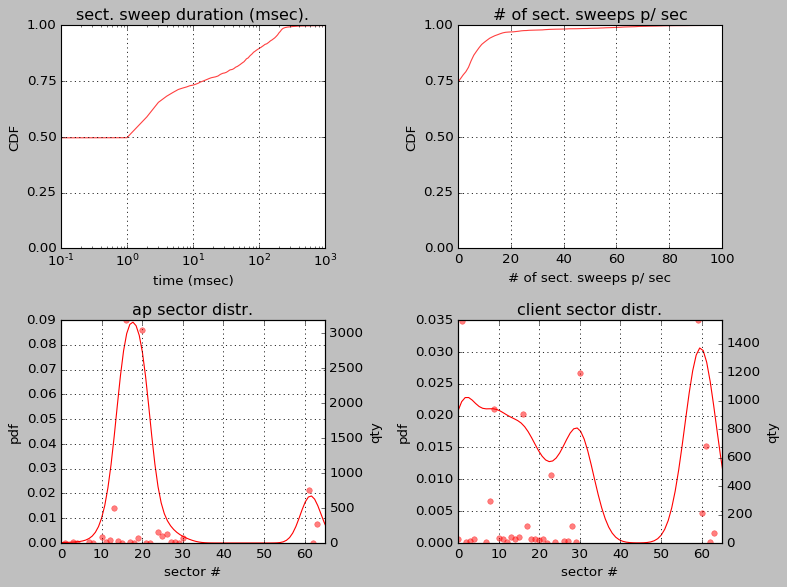

In [215]:
variables = {
    'a' : {
        'series' : [
            {'var' : 'duration',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'time (msec)',
        'x-lim' : [0.1, 1000.0],
        'x-type' : 'log',
        'plot-type' : 'cdf',
        'title' : 'sect. sweep duration (msec).',
    },
    'freq' : {
        'series' : [
            {'var' : 'freq',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : '# of sect. sweeps p/ sec',
        'x-lim' : [0, 100.0],
        'x-type' : 'linear',
        'plot-type' : 'cdf',
        'title' : '# of sect. sweeps p/ sec',
    },
    'c' : {
        'series' : [
            {'var' : 'wlan.sswf.sector_select.ap',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'sector #',
        'x-lim' : [0.0, 65.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'ap sector distr.',
    },
    'd' : {
        'series' : [
            {'var' : 'wlan.sswf.sector_select.client_1',
            'color' : 'red',
            'label' : ''},
        ],
        'x-label' : 'sector #',
        'x-lim' : [0.0, 65.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'client sector distr.',
    }
}

plt.style.use('classic')
fig = plt.figure(figsize = ((10.0), (7.5)))

plot_configs = {'x-label' : '', 'y-label' : '# of samples', 'title' : '', 'color' : 'blue'}
for i, var in enumerate(variables.keys()):
    plot_configs['x-label'] = variables[var]['x-label']
    plot_configs['x-lim'] = variables[var]['x-lim']
    plot_configs['x-type'] = variables[var]['x-type']
    plot_configs['title'] = variables[var]['title']
    plot_configs['plot-type'] = variables[var]['plot-type']
    
    ax = fig.add_subplot(2, 2, i + 1)
    
    if var == 'freq':
        # we consider all second precision timestamps 
        # for each 1 sec period, we calculate the nr. of sector sweeps
        ssw_freq = pd.DataFrame()
        ssw_freq['time'] = np.arange(sweep_blocks_fltrd['time'].min(), sweep_blocks_fltrd['timestamp'].max() + 1)
        ssw_freq = pd.merge(ssw_freq, sweep_blocks_fltrd.groupby(['time']).size().reset_index(name = 'freq', drop = False), on = ['time'], how = 'left')
        ssw_freq = ssw_freq.fillna(0)
        
        plot_distribution(ax, ssw_freq, var = variables[var]['series'], plot_configs = plot_configs)
    else:
        plot_distribution(ax, sweep_blocks_fltrd, var = variables[var]['series'], plot_configs = plot_configs)

fig.tight_layout()
plt.show()

* The duration of sector sweeps goes from ~1 ms in 50 % of the cases, up to 1 sec
* In 75% of the 1 second periods, there are no sector sweeps; in 90%, there are less than 20 sector sweeps per second
* The AP has clearly 2 sectors of preference, while the client chooses a wider range of sectors. **This is strange:** I would expect both to choose the same nr. of distinct sectors. If the AP chooses a sector in a particular direction, then the client should choose one in a complementary direction.